In [1]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

In [2]:
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
from scipy.signal import correlate2d
from scipy.signal import fftconvolve
from scipy.signal import convolve
from scipy.signal import correlate

# Contoh membaca file .mat
#data = sio.loadmat("BG450_model.mat")
data = np.loadtxt('../Vp0 model Padded.txt')
#print(data.keys())
# Misalkan velocity model ada di key tertentu, misalnya 'velocity_model':
vp = data.T/1000
vp0 = np.loadtxt('../Vp0 model Padded.txt').T
vp0 = (vp0)/1000
#vp0 = gaussian_filter(vp, 10) #velocity model intial

print(np.min(vp0))
print(np.max(vp0))

vp0.shape

1.47751
5.730220520405732


(1312, 297)

In [3]:
data

array([[1510.41      , 1510.41      , 1510.41      , ..., 1532.11      ,
        1532.11      , 1532.11      ],
       [1510.41      , 1510.41      , 1510.41      , ..., 1532.11      ,
        1532.11      , 1532.11      ],
       [1510.41      , 1510.41      , 1510.41      , ..., 1532.11      ,
        1532.11      , 1532.11      ],
       ...,
       [5188.56465363, 5188.56465363, 5188.56465363, ..., 3052.2041803 ,
        3052.2041803 , 3052.2041803 ],
       [5188.56465363, 5188.56465363, 5188.56465363, ..., 3052.2041803 ,
        3052.2041803 , 3052.2041803 ],
       [5188.56465363, 5188.56465363, 5188.56465363, ..., 3052.2041803 ,
        3052.2041803 , 3052.2041803 ]])

In [4]:
import segyio
import numpy as np
from collections import defaultdict

filename = '../MarmousiAcousticInvisibleSurface.sgy'

# Dictionary untuk menyimpan shot gathers
shot_data = defaultdict(list)

with segyio.open(filename, "r", ignore_geometry=True) as segyfile:
    segyfile.mmap()
    n_traces = segyfile.tracecount
    n_samples = segyfile.samples.size
    
    # Ambil ID field record (shot number) per trace
    shot_ids = segyfile.attributes(segyio.TraceField.FieldRecord)[:]
    
    # Kelompokkan trace per shot
    for i in range(n_traces):
        shot_id = shot_ids[i]
        trace = segyfile.trace[i]
        shot_data[shot_id].append(trace)

# Ubah list trace per shot menjadi array (samples x trace)
shot_gathers = []
for shot_id, traces in shot_data.items():
    gather = np.stack(traces).T  # shape: (samples, traces)
    shot_gathers.append(gather)

# Contoh: akses shot ke-0
first_shot = shot_gathers[0]
print("Shape of first shot:", first_shot.shape)


Shape of first shot: (1126, 160)


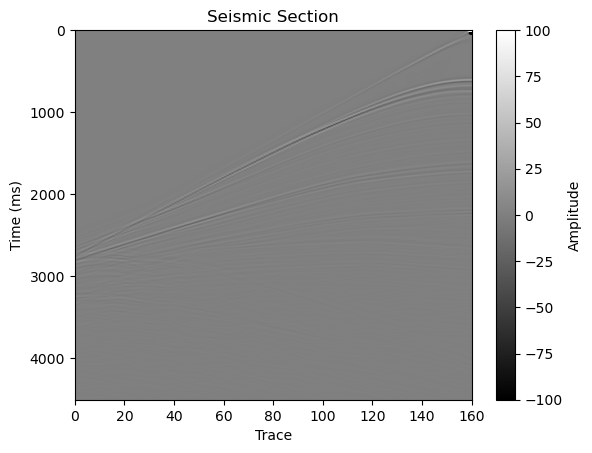

In [5]:
plt.imshow(shot_gathers[100], aspect='auto', cmap='gray', extent=[0, 160, 4504, 0], vmax=100, vmin=-100)
plt.xlabel('Trace')
plt.ylabel('Time (ms)')
plt.title('Seismic Section')
plt.colorbar(label='Amplitude')
plt.show()

In [6]:
nshots = 125  # Number of shots to create gradient from
nreceivers = 160  # Number of receiver locations per shot 
fwi_iterations = 5  # Number of outer FWI iterations

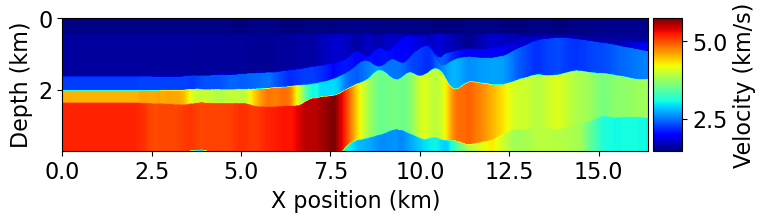

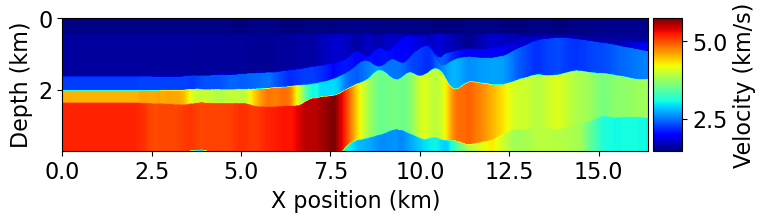

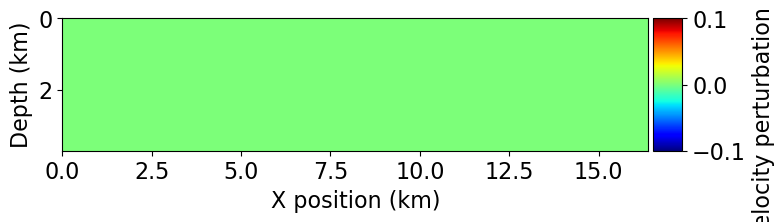

In [7]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, plot_velocity, plot_perturbation, Receiver

# Define a physical size
shape = (vp0.shape)  # Number of grid point (nx, nz)
spacing = (12.5, 12.5)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0.,0.)  # What is the location of the top left corner. This is necessary to define
nboundary = 40

model = Model(vp=vp, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp")

model0 = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)

plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

In [8]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry, TimeAxis, RickerSource, PointSource, WaveletSource

t0 = 0.
tn = 4500. 
dt = 4
time = TimeAxis(start=t0, stop=tn, step=dt)


f0 = 0.010

# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((nshots, 2))
src_coordinates[:, 0] = np.linspace(4050, 16450, nshots)
src_coordinates[:, 1] = 0.  # Depth is 20m

In [9]:
import examples.seismic as utils
utils.AcquisitionGeometry??


Init signature:
utils.AcquisitionGeometry(
    model,
    rec_positions,
    src_positions,
    t0,
    tn,
    dt,
    **kwargs,
)
Source:        
class AcquisitionGeometry(Pickable):
    """
    Encapsulate the geometry of an acquisition:
    - source positions and number
    - receiver positions and number

    In practice this would only point to a segy file with the
    necessary information
    """

    __rargs__ = ('grid', 'rec_positions', 'src_positions', 't0', 'tn')
    __rkwargs__ = ('f0', 'src_type', 'interpolation', 'r')

    def __init__(self, model, rec_positions, src_positions, t0, tn, dt, **kwargs):
        """
        In practice would be __init__(segyfile) and all below parameters
        would come from a segy_read (at property call rather than at init)
        """
        src_positions = np.reshape(src_positions, (-1, model.dim))
        rec_positions = np.reshape(rec_positions, (-1, model.dim))
        self.rec_positions = rec_positions
        self._nrec = rec_pos

In [10]:
import examples.seismic.utils as utils
print(utils.__file__)


/home/costa2009/anaconda3/lib/python3.12/site-packages/examples/seismic/utils.py


In [11]:
geometrys = []

for i in range(nshots):
    # Define acquisition geometry: receivers

    # Initialize receivers for synthetic and imaging data
    rec_coordinates = np.empty((nreceivers, 2))
    rec_coordinates[:, 0] = np.linspace((i*100), 4050+(i*100), nreceivers)
    rec_coordinates[:, 1] = 0.  # Depth is 20m

    # Geometry
    geometry = AcquisitionGeometry(model0, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker', dt=4)
    geometrys.append(geometry)

print(geometrys[0])
print(geometrys[0].time_axis)

TimeAxis: start=0, stop=4500, step=4, num=1126


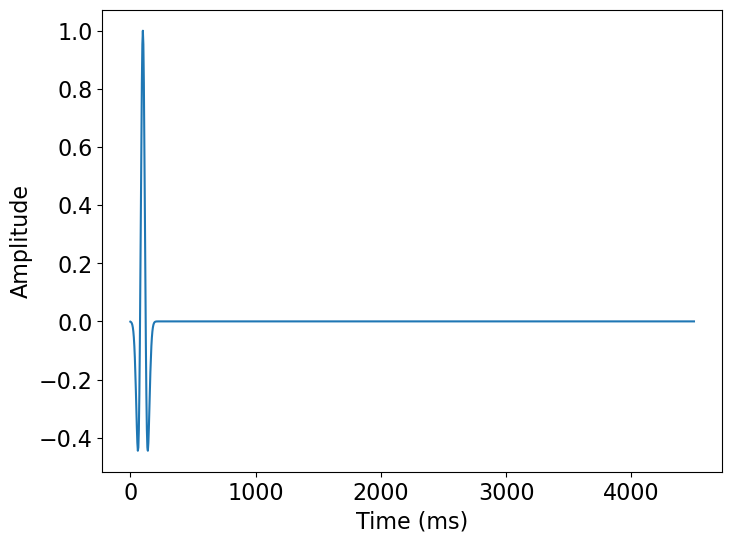

(1126, 1)

In [12]:
srct = []

for i in range(nshots):
    src = RickerSource(name='src', grid=model0.grid, f0=f0, time_range=time)
    # First, position source centrally in all dimensions, then set depth
    src.coordinates.data[0, :] = src_coordinates[i, 0]
    src.coordinates.data[0, -1] = 0.  # Depth is 20m
    #src.data[:] *= -1
    srct.append(src)
srct[0].show()
srct[0].data.shape

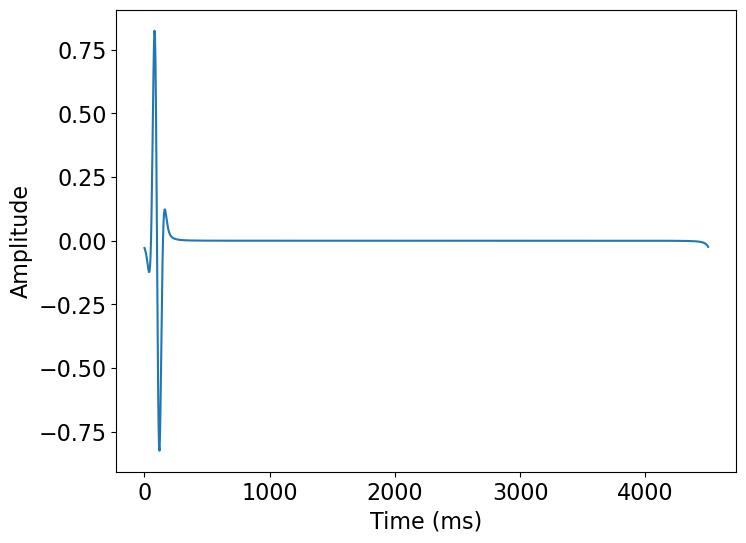

(1126, 1)

In [13]:
t = np.arange(t0, tn+dt, (dt))
t = t/1000
f0z = f0*1000
t0 = (1/f0z)
st = (1 - (2*(np.pi**2)*(f0z**2)*(t-t0)**2))*(np.exp(-1*(np.pi**2)*(f0z**2)*(t-t0)**2))

wavelet = st

angle = 90
shifted = np.real(np.exp(1j*np.radians(angle)) * signal.hilbert(wavelet))
shifted = np.array([shifted])
shiftedT = shifted.T

srcs = []

for i in range(nshots):
    src = RickerSource(name='src', grid=model0.grid, f0=f0, time_range=time)
    # First, position source centrally in all dimensions, then set depth
    src.coordinates.data[0, :] = src_coordinates[i, 0]
    src.coordinates.data[0, -1] = 0.  # Depth is 20m
    src.data[:] = shiftedT
    srcs.append(src)
srcs[0].show()
srcs[0].data.shape

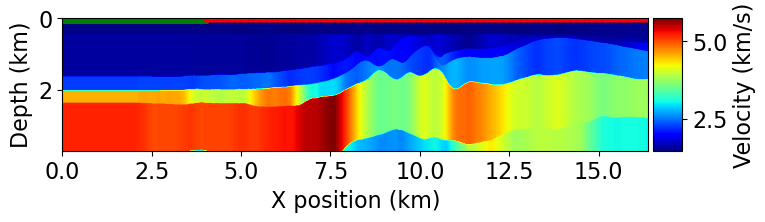

In [14]:
#NBVAL_IGNORE_OUTPUT
# Plot acquisition geometry
plot_velocity(model, source=geometrys[0].src_positions,
              receiver=geometrys[0].rec_positions)

In [15]:
# Mencari indeks geophone terdekat untuk setiap shot
nearest_indices = []
i=0
for shot in geometry.src_positions:
    distances = np.linalg.norm(geometrys[i].rec_positions - shot, axis=1)  # Hitung jarak Euclidean
    nearest_index = np.argmin(distances)  # Cari indeks dengan jarak minimum
    nearest_indices.append(nearest_index)
    i+=1

In [16]:
print(nearest_indices)

[159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159]


In [17]:
from devito import Eq, Operator

# Computes the residual between observed and synthetic data into the residual
def compute_residual(residual, dobs, dsyn, kg):
    if residual.grid.distributor.is_parallel:
        # If we run with MPI, we have to compute the residual via an operator
        # First make sure we can take the difference and that receivers are at the 
        # same position
        assert np.allclose(dobs.coordinates.data[:], dsyn.coordinates.data)
        assert np.allclose(residual.coordinates.data[:], dsyn.coordinates.data)
        # Create a difference operator
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        # Data ukuran (1920 x 120)
        data_1 = dsyn.data[:]
        data_2 = dobs.data[:]

        # Data ukuran (1920 x 120)
        

        # Pastikan data_2 menjadi array 1D untuk keperluan konvolusi
        filter_data1 = dobs.data[:,kg]
        filter_data2 = dsyn.data[:,kg]


        for i in range(residual.data.shape[1]):
            # Panjang data asli
            len_data1 = len(data_1)

            # Panjang hasil korelasi
            len_full = len(convolve(filter_data1, data_1[:, i], mode='full'))

            # Indeks untuk mengambil nilai tengah
            start = (len_full - len_data1) // 2
            end = start + len_data1
            
            residual.data[:, i] = convolve(data_1[:, i], filter_data1, mode='full')[:len_data1] - convolve(data_2[:, i], filter_data2, mode='full')[:len_data1]
            
         # Data berukuran (1920 x 1)
        
        data_1 = dobs.data[:,kg]

        # Data berukuran (1920 x 120)
        data_2 = residual.data[:]    
        # Menyimpan hasil cross-correlation
        cross_correlations = []
        len_data = len(data_1)
        # Lakukan cross-correlation untuk setiap kolom di data_2
        for i in range(data_2.shape[1]):
            result = correlate(data_2[:, i], data_1, mode='full')[len_data-1:]
            cross_correlations.append(result)
        residual.data[:] = np.array(cross_correlations).T
        
        #residual.data[:] = ((residual.data[:] - residual.data[:].min())/(residual.data[:].max()-residual.data[:].min()))*((dobs.data[:].max()-dobs.data.min())+dobs.data.min())
    return residual

In [18]:
def misfit(vp_in):
    objective = 0.
    for i in range(nshots):
        # Compute synthetic data with forward operator 
        from examples.seismic.acoustic import AcousticWaveSolver

        solver = AcousticWaveSolver(model0, geometrys[i], space_order=2)
        
        # Create placeholders for the data residual and data
        residual = Receiver(name='residual', grid=model0.grid,
                            time_range=geometrys[i].time_axis, 
                            coordinates=geometrys[i].rec_positions)
        d_obs = Receiver(name='d_obs', grid=model.grid,
                         time_range=geometrys[i].time_axis, 
                         coordinates=geometrys[i].rec_positions)
        d_syn = Receiver(name='d_syn', grid=model0.grid,
                        time_range=geometrys[i].time_axis, 
                        coordinates=geometrys[i].rec_positions)
        # Update source location
        #geometry.src_positions[0, :] = src_coordinates[i, :]

        # Generate synthetic data from true model
        #_, _, _ = solver.forward(vp=model.vp, src=srcs[i], rec=d_obs)
        d_obs.data[:] = shot_gathers[i]

        # Compute smooth data and full forward wavefield u0
        _, _, _ = solver.forward(vp=vp_in.vp, src=srcs[i], rec=d_syn)

        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn, nearest_indices[i])
        objective += 0.5*norm(residual)**2
    return objective
    

In [19]:
def linesearch(a, b, l, vp_in, ff,  g):
    from copy import deepcopy
    from devito import Function, TimeFunction, norm
    vp2 = deepcopy(vp_in)
    vp2.vp.data[:] = vp_in.vp.data[:] + l*(g.data[:]/1000)
    gnorm = a*l*norm(g)
    ff2 = misfit(vp2)
    ni = 1
    while (ff2 > ff - gnorm):
        l = b*l
        vp2.vp.data[:] = vp_in.vp.data[:] + l*(g.data[:]/1000)
        ff2 = misfit(vp2)
        gnorm = a*l*norm(g)
        print(ni)
        ni+=1
        if l < 1e-5:
            break
    return l

In [20]:
# Create FWI gradient kernel 
from devito import Function, TimeFunction, norm
from examples.seismic import Receiver, plot_shotrecord

import scipy
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model.grid)
    
    objective = 0.
    for i in range(nshots):
        # Compute synthetic data with forward operator 
        from examples.seismic.acoustic import AcousticWaveSolver

        solver = AcousticWaveSolver(model0, geometrys[i], space_order=2)
        
        # Create placeholders for the data residual and data
        residual = Receiver(name='residual', grid=model.grid,
                            time_range=geometrys[i].time_axis, 
                            coordinates=geometrys[i].rec_positions)
        d_obs = Receiver(name='d_obs', grid=model.grid,
                         time_range=geometrys[i].time_axis, 
                         coordinates=geometrys[i].rec_positions)
        d_syn = Receiver(name='d_syn', grid=model.grid,
                        time_range=geometrys[i].time_axis, 
                        coordinates=geometrys[i].rec_positions)

        
        # Update source location
        #geometry.src_positions[0, :] = src_coordinates[i, :]

        # Generate synthetic data from true model
        #_, _, _ = solver.forward(vp=model.vp, src=srcs[0i, rec=d_obs)
        d_obs.data[:] = shot_gathers[i]

        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, src=srcs[i], rec=d_syn)
        
        #plot_shotrecord(d_syn.data[:], model0, t0,tn)
        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn, nearest_indices[i])
        
        objective += .5*norm(residual)**2
        
        #plot_shotrecord(residual.data, model, t0, tn)
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
        
        
    gradNormalized = Function(name="gradNormalized", grid=model.grid)
    grad.data[:] *= watermute.data[:]
    grad.data[:] *= modelpadmute.data[:]
    #Normalisasi ke rentang [-1, 1]
    gradNormalized.data[:] = (grad.data)/np.abs(grad.data[:]).max()
    
        

    return objective, gradNormalized

In [21]:
waterheight = 36
watermute = Function(name="watermute", grid=model.grid)
watermute.data[:,nboundary+waterheight:] += 1

In [22]:
modelpad = 160
modelpadmute = Function(name="modelpadmute", grid=model.grid)
modelpadmute.data[nboundary+modelpad:,:] += 1
#modelpadmute.data[280-(nboundary+modelpad):280,:] = 0

In [23]:
modeli =[]
misfiti = []
gradi = []

update_model = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)
#plot_velocity(update_model)

modeli.append(update_model)

fwi_iterations = 3  # Number of outer FWI iteration
fwi_index = 0
for i in range(fwi_iterations):
    ff, update = fwi_gradient(update_model.vp)

    misfiti.append(ff)
    gradi.append(update)
    
    print(f"iterasi ke-{i} : {ff}")
    
    a = 0.25
    b = 0.5
    L = 100

    L = linesearch(a, b, L, update_model, ff,  update)

    
    update_model.vp.data[:] += (L*update.data[:]/1000)
    modeli.append(update_model)
    
    if i >= 2 :
        if (np.abs(ff-misfiti[i-1]))<1e-3:
            break
    fwi_index+=1

ff, update = fwi_gradient(update_model.vp)
misfiti.append(ff)
gradi.append(update)

print(f"iterasi ke-{fwi_index} : {ff}")

iterasi ke-0 : 6.422785442918336e+22
iterasi ke-1 : 6.375911057030337e+22
iterasi ke-2 : 6.347095282627152e+22
iterasi ke-3 : 6.328281510794771e+22


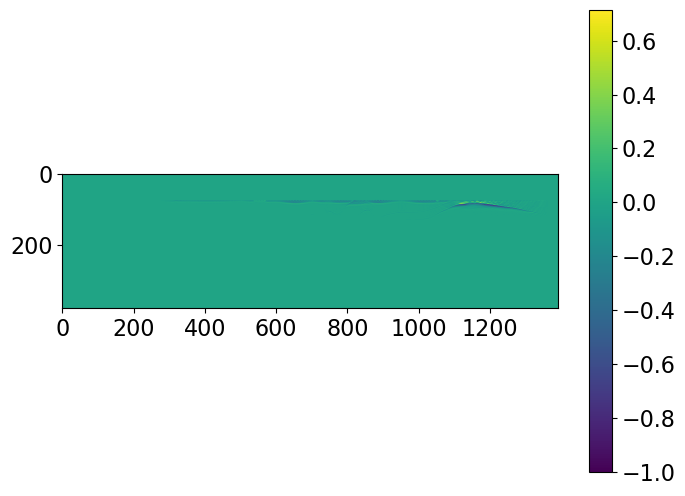

-1.0


In [24]:
import matplotlib.pyplot as plt
plt.imshow(update.data.T)
plt.colorbar()
plt.show()

print(update.data.min())

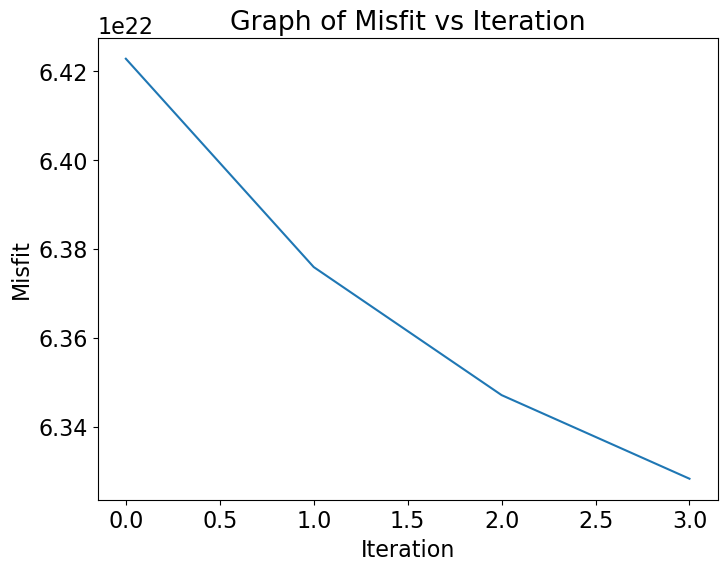

In [25]:
import matplotlib.pyplot as plt

plt.plot(misfiti)
plt.title("Graph of Misfit vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Misfit")
plt.show()

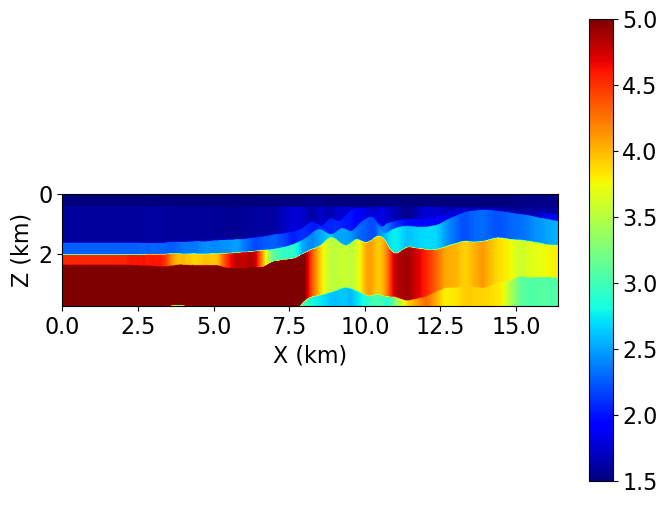

In [26]:
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(model0.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=5.0)
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

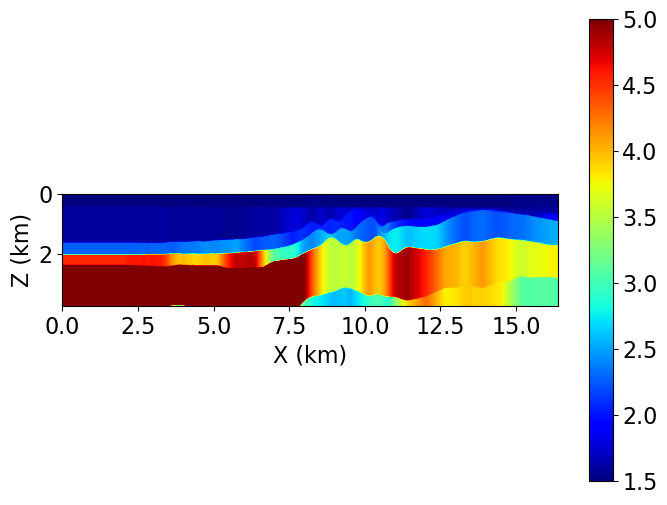

In [27]:
ibest = 0
min_misfit= 9999
for i in range(len(misfiti)):
    if misfiti[i]<min_misfit:
        min_misfit = misfiti[i]
        ibest = i
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(modeli[ibest].vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=5.0)
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

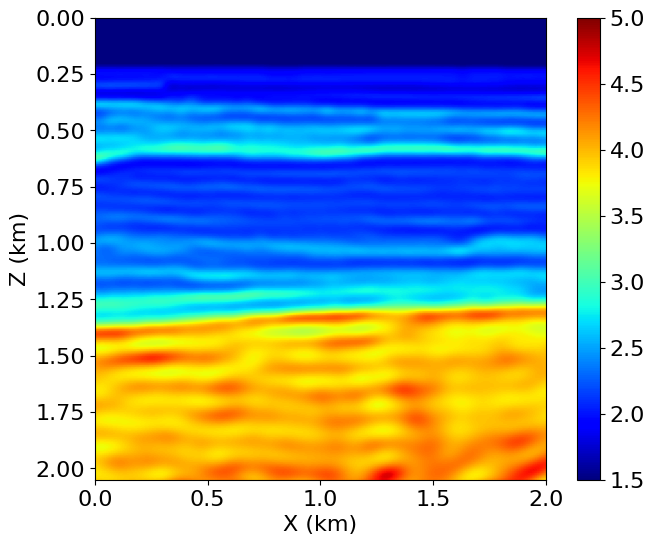

In [39]:
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(model.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=5.0)
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

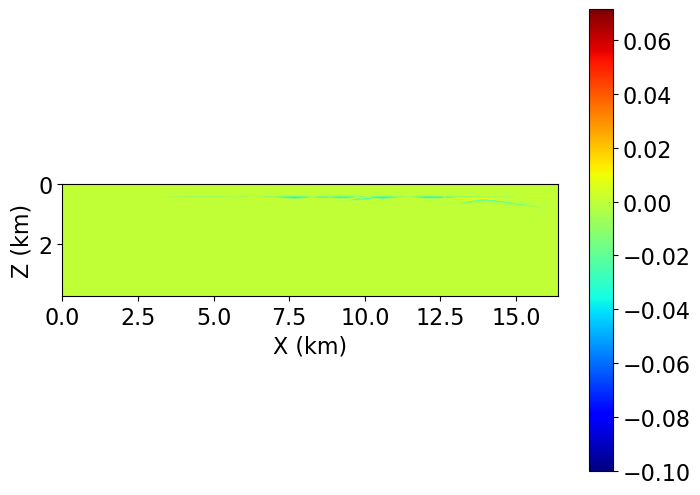

In [77]:
selisih_model = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)
selisih_model.vp.data[:] = modeli[ibest].vp.data[:] - model0.vp.data[:]
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(selisih_model.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

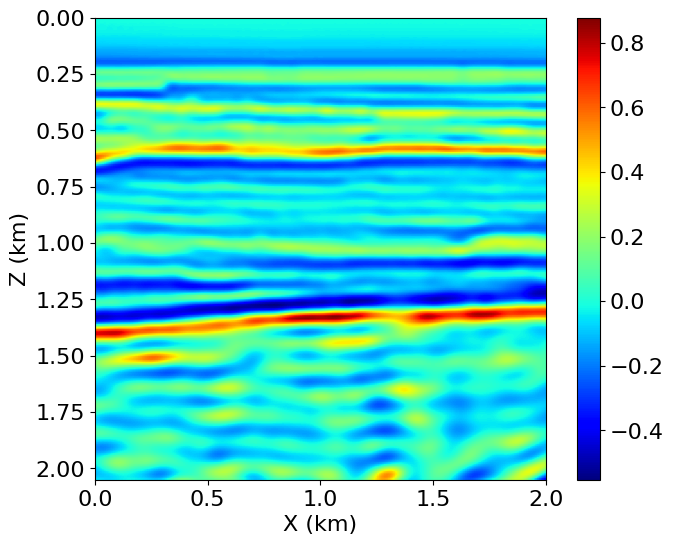

In [41]:
selisih_model1 = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)
selisih_model1.vp.data[:] = model.vp.data[:] - model0.vp.data[:]
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(selisih_model1.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

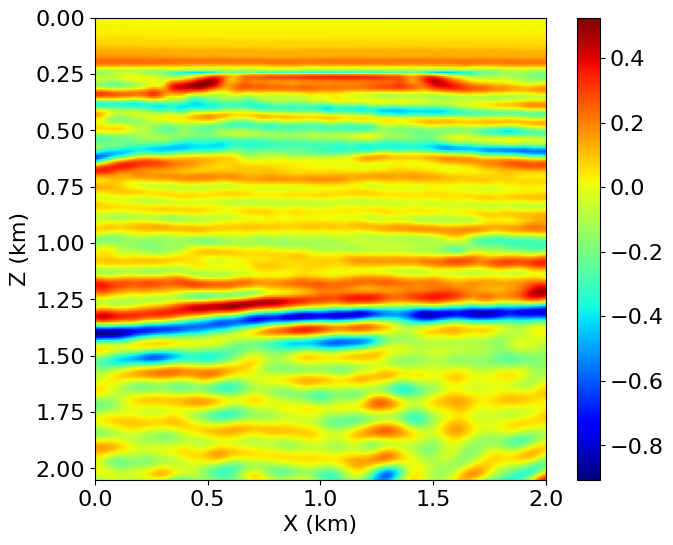

In [42]:
selisih_model2 = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)
selisih_model2.vp.data[:] = modeli[ibest].vp.data[:] - model.vp.data[:]
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(selisih_model2.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()